### GAIA optimisation DBSCAN with MCMC scheme

1. using a simple ABC scheme
2. Adding the weighting as an optimized set.

<b>IMPORTANT Note: abc_mcmc_dbscan_full not anymore synced with src version</b>

In [1]:
using PyCall
using Distributions
using Statistics , StatsBase

using Distances
using Random, Dates

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/testfull2"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

cd(wdir)

## dbcan and weighting parameters
#mutable struct modelfull
#    eps::Float64
#    min_nei::Int
#    min_cl::Int
#    w3d::Float64
#    wvel::Float64
#    whrd::Float64
#end

#### mutable Markov Chains to get the stationary df for the ABC-MCMC/dbscan opt,
#mutable struct mcfull
#    eps::Array{Float64}
#    mne::Array{Int32}
#    mcl::Array{Int32}
#    w3d::Array{Float64}
#    wvel::Array{Float64}
#    whrd::Array{Float64}
#    qc::Array{Float64}
#    qn::Array{Int32}
#end

## parameters for the ABC MCMC optimization of the dbscan
#struct abcfull
#    minQ::Float64
#    minstars::Int
#    forcedminstars::Int
#    epsmean::Float64
#    epsdisp::Float64
#    min_nei::Int
#    min_cl::Int
#    ncoredisp::Int
#    w3dmean::Float64
#    w3ddisp::Float64
#    wvelmean::Float64
#    wveldisp::Float64
#    whrdmean::Float64
#    whrddisp::Float64
#    nburnout::Int
#    niter::Int
#end

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling GaiaClustering [top-level]
└ @ Base loading.jl:1273


In [2]:
function getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
 
    return(dfcart)
end

getdata (generic function with 1 method)

In [3]:
function _find_clusters(df::GaiaClustering.Df, dfcart::GaiaClustering.Df , m::GaiaClustering.modelfull, 
    aperture2d = 1.5, maxaperture2d = 15, aperturev = 3.0, maxaperturev = 20, nboot = 30)
    let 
        labels = clusters(df.data , m.eps , 20, m.min_nei, m.min_cl)
        if length(labels) == 0
            return(0, 0)
        end
        
    ### metrics of the clusters
        q2d = metric2(dfcart, labels, "spatial2d" , aperture2d, maxaperture2d, nboot)
        q3d = metric2(dfcart, labels, "spatial3d" , aperture2d, maxaperture2d, nboot)     #### Added 
        qv  = metric2(dfcart, labels, "velocity" , aperturev, maxaperturev, nboot)
        
        #### qp, qa = metric2(dfcart, labels, "HRD" )
    
        nlab = []
        for ilab in labels
            push!(nlab,length(ilab))
        end
    
    
    #### metric for the number of stars in the cluster
        qn = []
        for nl in nlab
            push!(qn,log10(nl))
        end
    
        qc = 0.
        qstar = 0
        for i in 1:length(nlab)
            k1 = q2d[i][1]
            k1bis = q3d[i][1]
            k2 = qv[i][1]
            ### k3 = qa[i][1]
            k3=0
            ###
            k4 = qn[i]
            ############### Composite metric ### changed denominator to 6.0 since k3=0
            qq = (3k1 + k1bis + 3k2 + k3 + k4) / 8.0
            ###############
            if qq > qc 
                qc = qq
                qstar = nlab[i]
            end
        end
        return(qc, qstar)
    end
end


_find_clusters (generic function with 6 methods)

In [4]:
### plot the stats of the DBSCAN parameters from the MCMC
function _plot_dbscanfull_mcmc(plotdir, voname, mc::GaiaClustering.mcfull , showplot = true)
    PyPlot.plt[:figure](figsize=(12.0,13.0))

    nbins = 50
    PyPlot.plt[:subplot](3, 3, 1  )
    h = PyPlot.plt[:hist](mc.eps,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("ϵ")
    PyPlot.plt[:grid](true)
    
    nbins = 20
    PyPlot.plt[:subplot](3, 3, 2 )
    h = PyPlot.plt[:hist](mc.mne,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("min_neighbor")  
    PyPlot.plt[:grid](true)
    
    nbins = 20
    PyPlot.plt[:subplot](3, 3, 3 )
    h = PyPlot.plt[:hist](mc.mcl,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("min_cluster") 
    PyPlot.plt[:grid](true)
    
    nbins = 50
    PyPlot.plt[:subplot](3, 3, 4 )
    h = PyPlot.plt[:hist](mc.w3d,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("W3d") 
    PyPlot.plt[:grid](true)  
    
    nbins = 50
    PyPlot.plt[:subplot](3, 3, 5 )
    h = PyPlot.plt[:hist](mc.wvel,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("Wvel") 
    PyPlot.plt[:grid](true)
    
    nbins = 50
    PyPlot.plt[:subplot](3, 3, 6 )
    h = PyPlot.plt[:hist](mc.whrd,nbins, alpha=0.75)
    PyPlot.plt[:xlabel]("Whrd") 
    PyPlot.plt[:grid](true)   
    
    
    #######
    nbins = 50
    PyPlot.plt[:subplot](3, 3, 7 )
    PyPlot.plt[:axis]("on")
    h = PyPlot.plt[:hist](mc.qn,nbins, color = "g", alpha=0.75)
    PyPlot.plt[:xlabel]("Qn")     
    PyPlot.plt[:grid](true)
    
    nbins = 50
    PyPlot.plt[:subplot](3, 3, 8 )
    h = PyPlot.plt[:hist](mc.qc,nbins, color="g", alpha=0.75)
    PyPlot.plt[:xlabel]("Qc") 
    PyPlot.plt[:grid](true)

        ### text 

    PyPlot.plt[:subplot](3, 3, 9)
    PyPlot.plt[:axis]("off")
    ## text to display
        text =[]
        push!(text, "VOT: "*voname)
        vtext  = mean(mc.eps)
        v2text = std(mc.eps)
        txt = "ϵ : $vtext +/- $v2text "
        push!(text,txt)
        vtext  = mean(mc.mne)
        v2text = std(mc.mne)
        txt = "min_neigh : $vtext +/- $v2text " 
        push!(text,txt)
        vtext  = mean(mc.mcl)
        v2text = std(mc.mcl)
        txt = "min_clus : $vtext +/- $v2text "  
        push!(text,txt)
        vtext  = mean(mc.w3d)
        v2text = std(mc.w3d)
        txt = "W3d : $vtext +/- $v2text "  
        push!(text,txt)   
        vtext  = mean(mc.wvel)
        v2text = std(mc.wvel)
        txt = "Wvel : $vtext +/- $v2text "  
        push!(text,txt)    
        vtext  = mean(mc.whrd)
        v2text = std(mc.whrd)
        txt = "Whrd : $vtext +/- $v2text "  
        push!(text,txt)     
        vtext  = mean(mc.qn)
        v2text = std(mc.qn)
        txt = "Qn : $vtext +/- $v2text "
        push!(text,txt)
        vtext  = mean(mc.qc)
        v2text = std(mc.qc)
        txt = "Qc : $vtext +/- $v2text "
        push!(text,txt)
        show_text(-0.01,0.0, text)   
    
    PyPlot.plt[:xlabel]("Qc") 
    figname = plotdir*"/"*voname*"-dbscanMCMC-full.png"
    PyPlot.plt[:savefig](figname)
    if showplot PyPlot.plt[:show]() end
end

_plot_dbscanfull_mcmc (generic function with 2 methods)

In [5]:
function _theta(p::GaiaClustering.abcfull)
    #peps         = TruncatedNormal(p.epsmean, p.epsdisp, 0.1 , 1000)
    #pminnei      = TruncatedNormal(p.min_nei, p.ncoredisp, 1 , 1000.)
    #pmincl       = TruncatedNormal(p.min_cl, p.ncoredisp, 1 , 1000.)
    #pw3d         = TruncatedNormal(p.w3dmean , p.w3ddisp, 0.1, 1000)
    #pwvel        = TruncatedNormal(p.wvelmean , p.wveldisp, 0.1, 1000)
    #pwhrd        = TruncatedNormal(p.whrdmean , p.whrddisp, 0.1, 1000)
    
    peps         = truncated(Normal(p.epsmean, p.epsdisp), 0.1 , 1000)
    pminnei      = truncated(Normal(p.min_nei, p.ncoredisp), 1 , 1000.)
    pmincl       = truncated(Normal(p.min_cl, p.ncoredisp), 1 , 1000.)
    pw3d         = truncated(Normal(p.w3dmean , p.w3ddisp), 0.1, 1000)
    pwvel        = truncated(Normal(p.wvelmean , p.wveldisp), 0.1, 1000)
    pwhrd        = truncated(Normal(p.whrdmean , p.whrddisp), 0.1, 1000)   
    
    
    e = rand(peps)          ; pe = pdf(peps,e)
    n = trunc(Int,rand(pminnei))  ; pn = pdf(pminnei, n)
    c = trunc(Int,rand(pmincl))   ; pc = pdf(pmincl, c)
    w3 = rand(pw3d)          ; pw3 = pdf(pw3d,w3)   
    wv = rand(pwvel)         ; pwv = pdf(pwvel,wv)  
    wh = rand(pwhrd)         ; pwh = pdf(pwhrd,wh)  
    
    ptotal = pe*pn*pc*pw3*pwv*pwh
    params = modelfull(e, n, c , w3, wv, wh)
    return(params, ptotal)
end


## iterate with random walk and yield the probability
##
function _thetaiter(θi::GaiaClustering.modelfull , p::GaiaClustering.abcfull)
    let   
        # peps         = TruncatedNormal(p.epsmean, p.epsdisp, 0.1 , 1000)
        peps         = truncated(Normal(p.epsmean, p.epsdisp), 0.1, 1000)       
        # pminnei      = TruncatedNormal(p.min_nei, p.ncoredisp, 1 , 1000.)
        pminnei      = truncated(Normal(p.min_nei, p.ncoredisp), 1 , 1000.)
        #pmincl       = TruncatedNormal(p.min_cl, p.ncoredisp, 1 , 1000.)
        pmincl       = truncated(Normal(p.min_cl, p.ncoredisp), 1 , 1000.)
        #pw3d         = TruncatedNormal(p.w3dmean , p.w3ddisp, 0.1, 1000)
        pw3d         = truncated(Normal(p.w3dmean , p.w3ddisp), 0.1, 1000)
        # pwvel        = TruncatedNormal(p.wvelmean , p.wveldisp, 0.1, 1000)
        pwvel        = truncated(Normal(p.wvelmean , p.wveldisp), 0.1, 1000)
        # pwhrd        = TruncatedNormal(p.whrdmean , p.whrddisp, 0.1, 1000)       
        pwhrd        = truncated(Normal(p.whrdmean , p.whrddisp), 0.1, 1000)
        
        #eps_rw    = TruncatedNormal(θi.eps,0.4 , 0.1, 1000.)
        #minnei_rw = TruncatedNormal(θi.min_nei , 4  , 1,  1000.)
        #mincl_rw  = TruncatedNormal(θi.min_cl  , 4  , 1, 1000.)
        #w3d_rw    = TruncatedNormal(θi.w3d,  0.4, 0.1, 1000)
        #wvel_rw   = TruncatedNormal(θi.wvel, 0.4, 0.1, 1000)
        #whrd_rw   = TruncatedNormal(θi.whrd, 0.4, 0.1, 1000)
        
        eps_rw    = truncated(Normal(θi.eps,0.4) , 0.1, 1000.)
        minnei_rw = truncated(Normal(θi.min_nei , 4 ) , 1,  1000.)
        mincl_rw  = truncated(Normal(θi.min_cl  , 4)  , 1, 1000.)
        w3d_rw    = truncated(Normal(θi.w3d,  0.4), 0.1, 1000)
        wvel_rw   = truncated(Normal(θi.wvel, 0.4), 0.1, 1000)
        whrd_rw   = truncated(Normal(θi.whrd, 0.4), 0.1, 1000)        
        
        
        
        new_e = 0.
        new_mn = 0
        new_mcl = 0
        new_w3d = 0.
        new_wvel = 0.
        new_whrd = 0.
        
        iternotfound = true
        while iternotfound
            new_e    = rand(eps_rw)
            new_mn   = trunc(Int,rand(minnei_rw))      
            new_mcl  = trunc(Int,rand(mincl_rw))      
            new_w3d  = rand(w3d_rw)
            new_wvel = rand(wvel_rw)
            new_whrd = rand(whrd_rw)
            
            ### adding the condition on minclusterand > minnei..
            if new_e > 0 && new_mn > 0 && new_mcl > 0 && new_mn <= new_mcl
                iternotfound = false
            end
        end
    
        pe = pdf(peps , new_e)
        pn = pdf(pminnei, new_mn)
        pc = pdf(pmincl, new_mcl)
        pw3 = pdf(pw3d, new_w3d)   
        pwv = pdf(pwvel, new_wvel)  
        pwh = pdf(pwhrd, new_whrd)        
        
        ptotal = pe * pn * pc * pw3 * pwv * pwh
        params = modelfull(new_e, new_mn, new_mcl , new_w3d, new_wvel, new_whrd)
        return(params, ptotal)
    end
end   

#### function to adapt the minimum condition to evaluate the  solution
###
function _check_qminqstar_full(dfcart::GaiaClustering.Df,
        params::GaiaClustering.abcfull, minimumQ, minstars)
    let
        new_minq = minimumQ
        new_minstars = minstars
        notfound = true
        
        mingoodsolution = 20
        niter = 500
        
        println("### Checking the minQ and minStars conditions...")
        println("### Minimum good solutions $mingoodsolution")
        
        while notfound
            goodsolutions = 0
            for i in 1:niter
                mi, probi = _theta(params)
                dfcartnorm = _getDfcartnorm(dfcart , mi)
                qres , nstars = _find_clusters(dfcartnorm, dfcart, mi)
                println("### $i")
                println("### $qres $nstars")
                if qres > new_minq && nstars >= new_minstars
                    goodsolutions += 1
                    println("#### good solutions $goodsolutions")
                end
                if goodsolutions > mingoodsolution
                    notfound = false
                    return(new_minq, new_minstars)
                end
            end
            if notfound 
                new_minq *= 0.95
                new_minstars = trunc(Int, 0.95 * new_minstars)
                println("### MinQ not reached yet... testing $new_minq")
            end
            
            if new_minstars == 0
                println("### Problem with minStars, return(0.5,5)")
                return(0.5,5)
            end      
        end
        return(new_minq, new_minstars)
    end
end

function _getDfcartnorm(dfcart::GaiaClustering.Df, mc::GaiaClustering.modelfull) 
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [mc.w3d, mc.wvel, mc.whrd]
    norm       = "identity"
    
    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false, false)
    return(dfcartnorm)
end

## ABC MCMC (following Weyan et al. 2013)
## DBSCAN with parameters and weighting
##
function _abc_mcmc_dbscan_full(dfcart::GaiaClustering.Df, params::GaiaClustering.abcfull)
    let 
        println("## LOCAL !!ABC/MCMC for DBSCAN FULL...")
        mci = mcfull(zeros(Float64,0),zeros(Int32,0),zeros(Int32,0) , zeros(Float64,0), zeros(Int32,0), 
        zeros(Float64,0), zeros(Float64,0), zeros(Float64,0))
        
        initial = true
        th = []
        mi = modelfull(0.0,0,0, 0., 0., 0.)
        micurrent = modelfull(0.0,0,0, 0., 0., 0.)
        probi = 0.
        probcurrent = 0.
    
        minimumQ = params.minQ
        minstars = params.minstars
        niter = params.niter
        nburn = params.nburnout
    
        println("### Minimum Q : $minimumQ")
        println("### Minimum nstars : $minstars")
        minimumQ , minstars = _check_qminqstar_full(dfcart, params, minimumQ, minstars)
        println("### Minimum Q : $minimumQ")
        println("### Minimum nstars : $minstars")
        if minstars < params.forcedminstars
            minstars = params.forcedminstars
            println("### Minimum nstars forced to : $minstars") 
        end
            
        while initial
            mi, probi = _theta(params)
            dfcartnorm = _getDfcartnorm(dfcart , mi)
            qres , nstars = _find_clusters(dfcartnorm, dfcart, mi)
            if qres > minimumQ && nstars >= minstars 
                println("### init done ...")
                initial = false
                push!(mci.eps, mi.eps)
                push!(mci.mne, mi.min_nei)
                push!(mci.mcl, mi.min_cl)
                push!(mci.w3d, mi.w3d)
                push!(mci.wvel, mi.wvel)
                push!(mci.whrd, mi.whrd)
                push!(mci.qc,  qres)
                push!(mci.qn,  nstars)
            end
        end

        ## ministats iter changed to 50
        _ministats(50, dfcart, mi , params)
        
        nchain = 1
        loopAgain = true
        burndone = false
                    
        while loopAgain
            micurrent, probcurrent = _thetaiter(mi , params)
            dfcartnorm = _getDfcartnorm(dfcart , micurrent)
            qres , nstars = _find_clusters(dfcartnorm, dfcart, micurrent)
        
            if qres > minimumQ && nstars >= minstars 
            ### Metropolis-Hasting
                α = probcurrent / probi
                if α > rand()
                    mi = micurrent
                    probi = probcurrent
                    nchain += 1
                    if (nchain%500 == 0) println("### chain:",nchain) end
                    if nchain > nburn && !burndone println("### burnout done...") ; nchain = 0 ; burndone = true end
                    if nchain > niter loopAgain = false end
                    if burndone
                        push!(mci.eps, mi.eps)
                        push!(mci.mne, mi.min_nei)
                        push!(mci.mcl, mi.min_cl)
                        push!(mci.w3d, mi.w3d)
                        push!(mci.wvel, mi.wvel)
                        push!(mci.whrd, mi.whrd)
                        push!(mci.qc , qres)
                        push!(mci.qn,  nstars)
                    end
                end
            end
        end
        println("## ABC/MCMC done")
        println("##")
        return(mci)
    end
end


## mini stats over Qc and Qn
function _ministats(niter::Int, dfcart::GaiaClustering.Df, mi::GaiaClustering.modelfull, params::GaiaClustering.abcfull)
    println("### mini stats...")
    qcmini = []
    qnmini = []
    for i in 1:niter
        mitest, probtest = _thetaiter(mi , params)
        dfcartnorm = _getDfcartnorm(dfcart , mitest)
        
        qtest , ntest = _find_clusters(dfcartnorm, dfcart, mitest)
        push!(qcmini,qtest)
        push!(qnmini,ntest)
    end
    println("### Qc : ",mean(qcmini))
    println("### Qn : ",mean(qnmini))    
    
    return(0)
end

_ministats (generic function with 1 method)

## Main ...
## Starting at 2020-03-10T14:57:35.845
## Votable test.vot read
## Filtering done ...
## Stars selected: 143644
## Cartesian transformation done ...
## MCMC : Q minimum  = 2.7
## MCMC : N stars minimum = 40
## MCMC : iterations = 8000
## ABC/MCMC for DBSCAN FULL (parameters+weighting)...
### Minimum Q : 2.7
### Minimum nstars : 40
### Checking the minQ and minStars conditions...
### Minimum good solutions 50
### Minimum Q : 2.7
### Minimum nstars : 40
### init done ...
### mini stats...
### Qc : 2.719846052603348
### Qn : 4877.16
### chain:500
### chain:1000
### chain:1500
### chain:2000
### burnout done...
### chain:500
### chain:1000
### chain:1500
### chain:2000
### chain:2500
### chain:3000
### chain:3500
### chain:4000
### chain:4500
### chain:5000
### chain:5500
### chain:6000
### chain:6500
### chain:7000
### chain:7500
### chain:8000
## ABC/MCMC FULL done
##
## MCMC done.


┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:3
└ @ Main ./In[4]:3
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:6
└ @ Main ./In[4]:6
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:7
└ @ Main ./In[4]:7
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:97
└ @ Main ./In[4]:97
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:99
└ @ Main ./In[4]:99


## DBSCAN/MCMC stats:
### ϵ : 2.04053414428712 +/- 0.6802495377560352
### min_nei  : 8.231288266899913 +/- 4.82390331230368
### min_clus  : 18.036986130201175+/- 6.570375868503962
### W3d   : 5.756109512888398+/- 2.6270271791222712
### Wvel   : 7.777544753418658+/- 3.2189492255379153
### Whrd   : 2.1107463462835327+/- 0.9119772928082542
### Qn  : 2915.2460327377235 +/- 1001.52631958825
### Qc  : 3.47535603115671 +/- 0.33145033431736304
## Ending at 2020-03-10T19:02:10.136
## Duration: 4.076191944444444 hours
## done

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = _plot_dbscanfull_mcmc(::String, ::String, ::mcfull, ::Bool) at In[4]:100
└ @ Main ./In[4]:100


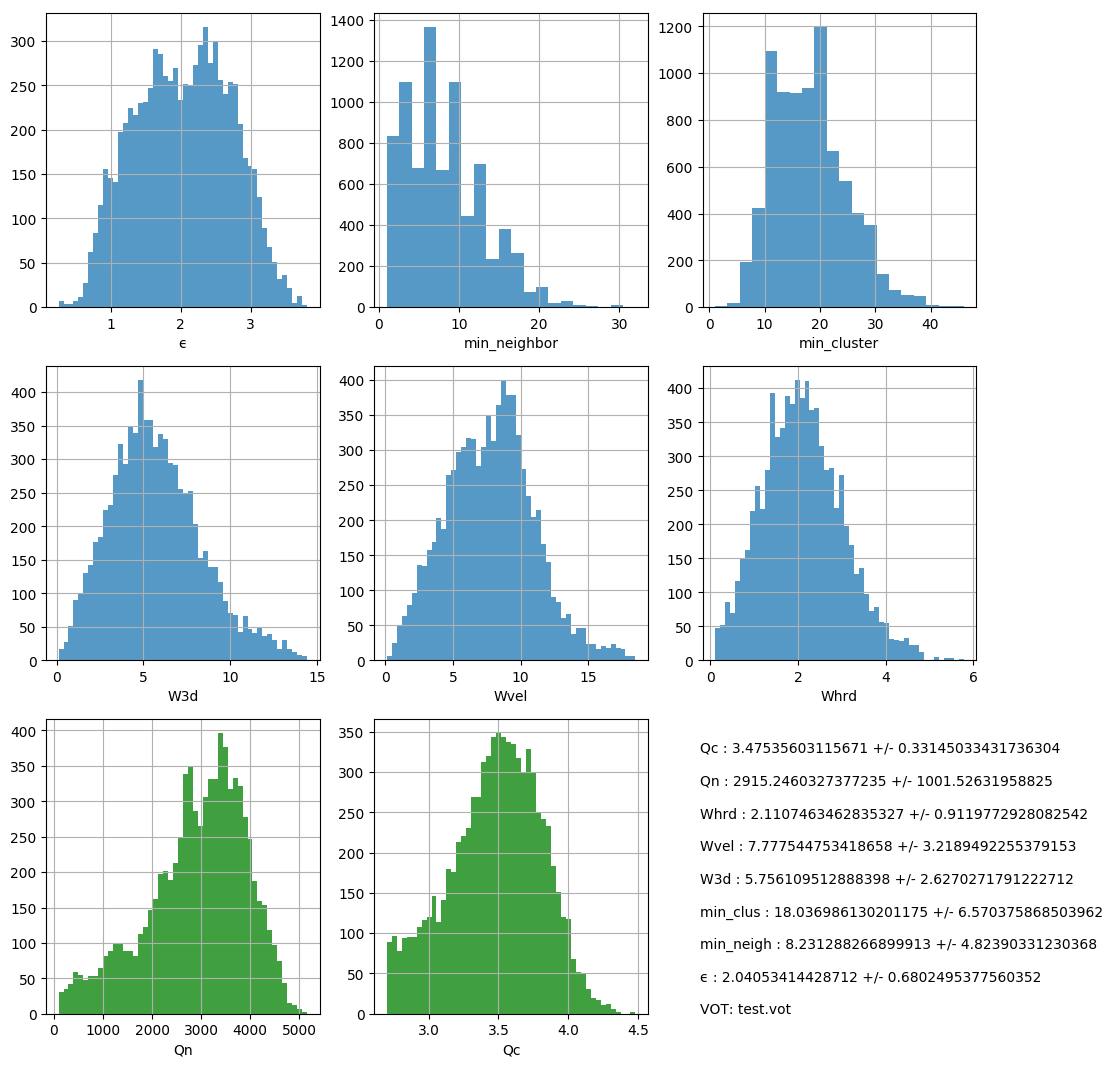

In [6]:
### main loop

function main(params::GaiaClustering.abcfull)
    Random.seed!()
    println("## Main ...")
    println("## Starting at $tstart")
    # println("##### Test disconnecting HRD metric")
    
    ## Get the cluster data..
    voname = "test.vot"
    dfcart = getdata(voname)
    
    ## run the mcmc for the dbscan parameters

    println("## MCMC : Q minimum  = ", params.minQ)
    println("## MCMC : N stars minimum = ", params.minstars)
    println("## MCMC : iterations = ", params.niter)
    
    # mc = _abc_mcmc_dbscan_full(dfcart, params)
    mc = abc_mcmc_dbscan_full(dfcart, params)
    
    println("## MCMC done.")
    
    ## plots ################################
    _plot_dbscanfull_mcmc(plotdir, voname, mc, true)
    
    ## Stats
    println("## DBSCAN/MCMC stats:")
    println("### ϵ : ",mean(mc.eps)," +/- ", std(mc.eps))
    println("### min_nei  : ",mean(mc.mne)," +/- ", std(mc.mne))
    println("### min_clus  : ",mean(mc.mcl),"+/- ", std(mc.mcl))
    println("### W3d   : ", mean(mc.w3d) , "+/- ", std(mc.w3d))
    println("### Wvel   : ", mean(mc.wvel) , "+/- ", std(mc.wvel))
    println("### Whrd   : ", mean(mc.whrd) , "+/- ", std(mc.whrd))
    println("### Qn  : ",mean(mc.qn)," +/- ", std(mc.qn)) 
    println("### Qc  : ",mean(mc.qc)," +/- ", std(mc.qc)) 
    
    return(mc)        
end

#################
### main 
minQ    = 2.7
minstars = 40
forcedminstars = 30
##
epsmean   = 2.5
epsdisp   = 1.5
min_nei   = 10
min_cl    = 15
ncoredisp = 10
w3dmean   = 5.0
w3ddisp   = 4.0
wvelmean  = 5.0
wveldisp  = 4.0
whrdmean  = 2.0
whrddisp  = 1.0
##
nburnout  = 2000
niter     = 8000


pinit = GaiaClustering.abcfull(minQ, minstars, forcedminstars, epsmean, epsdisp, min_nei, min_cl, ncoredisp, w3dmean, w3ddisp ,
    wvelmean, wveldisp, whrdmean, whrddisp, nburnout , niter)
##
tstart= now()
mc= main(pinit)
tend= now()
println("## Ending at $tend")
duration= Dates.value(tend-tstart) / (1000*3600)
println("## Duration: $duration hours")
println("## done")

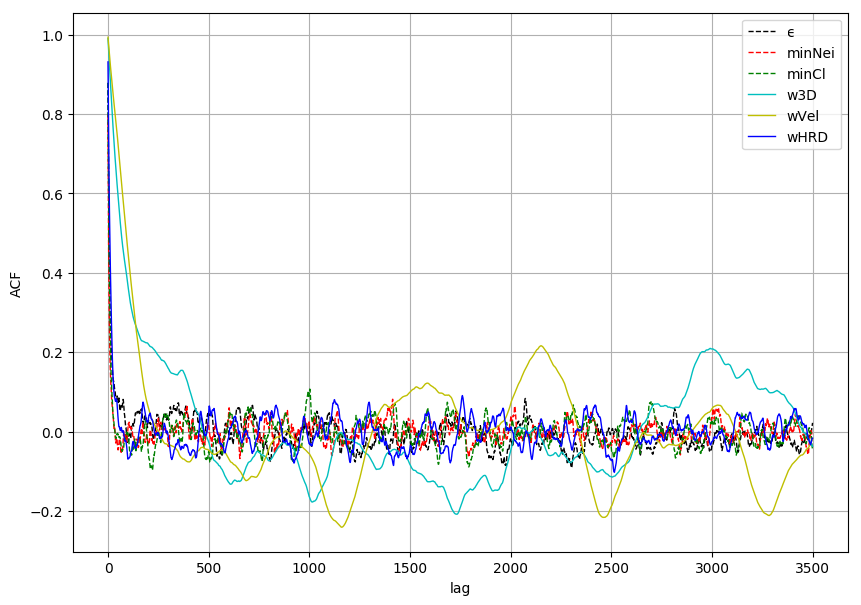

In [7]:
## plots the ABC check (ACF)

fig = PyPlot.figure(figsize=(10,7))

lags= collect(1:3500)
ax = PyPlot.subplot(111)
PyPlot.grid("on")
PyPlot.xlabel("lag")
PyPlot.ylabel("ACF")
PyPlot.plot(StatsBase.autocor(mc.eps, lags), "k--", linewidth= 1, label="ϵ")
PyPlot.plot(StatsBase.autocor(mc.mne, lags), "r--", linewidth= 1, label="minNei")
PyPlot.plot(StatsBase.autocor(mc.mcl, lags), "g--", linewidth= 1, label="minCl")
PyPlot.plot(StatsBase.autocor(mc.w3d, lags), "c-", linewidth= 1,label="w3D"  )
PyPlot.plot(StatsBase.autocor(mc.wvel, lags), "y-", linewidth= 1,label="wVel" )
PyPlot.plot(StatsBase.autocor(mc.whrd, lags), "b-", linewidth= 1, label="wHRD")

PyPlot.legend()

PyPlot.savefig("$plotdir/abc-dbscan-ACF.eps")
PyPlot.show()


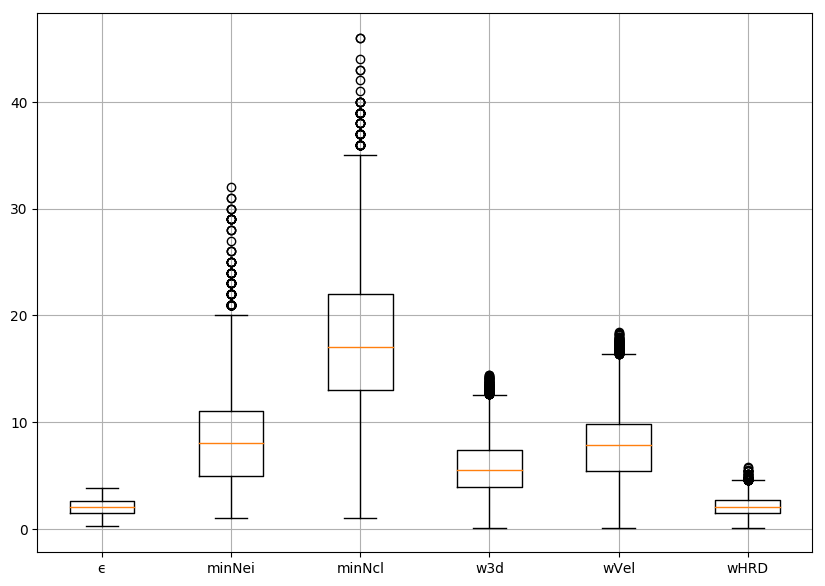

In [8]:
## boxplot of the ABC results
data = [mc.eps ,mc.mne, mc.mcl , mc.w3d, mc.wvel, mc.whrd]

fig = PyPlot.figure(figsize=(10,7))
# ax = PyPlot.subplot(111)
# PyPlot.yscale("log")
PyPlot.grid("on")
PyPlot.boxplot(data, labels=["ϵ","minNei","minNcl","w3d","wVel","wHRD"])

PyPlot.savefig("$plotdir/abc-dbscan-boxplot.eps")
PyPlot.show()

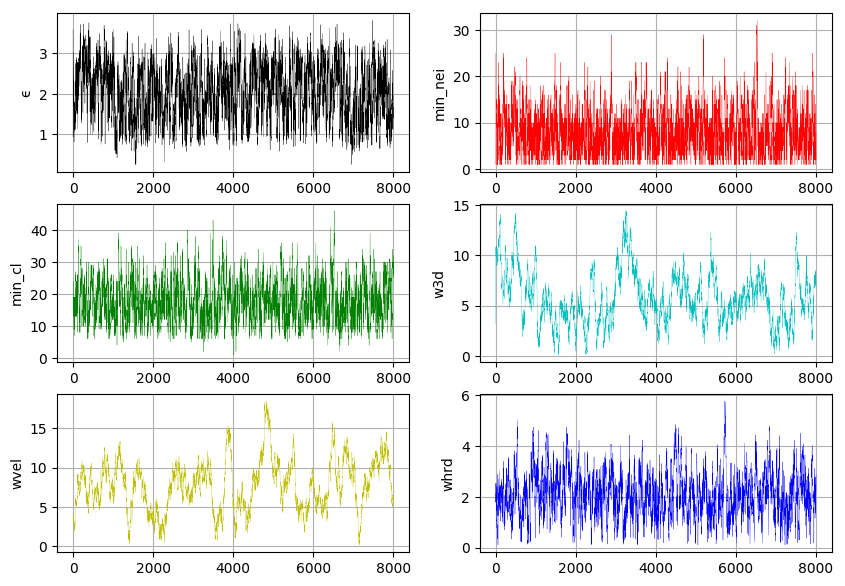

In [9]:
## plot traces...


fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(321)
PyPlot.grid("on")
PyPlot.ylabel("ϵ")
PyPlot.plot(mc.eps, "k-", linewidth=0.2)

ax = PyPlot.subplot(322)
PyPlot.grid("on")
PyPlot.ylabel("min_nei")
PyPlot.plot(mc.mne, "r-", linewidth=0.2)

ax = PyPlot.subplot(323)
PyPlot.grid("on")
PyPlot.ylabel("min_cl")
PyPlot.plot(mc.mcl, "g-", linewidth=0.2)

ax = PyPlot.subplot(324)
PyPlot.grid("on")
PyPlot.ylabel("w3d")
PyPlot.plot(mc.w3d, "c-", linewidth=0.2)

ax = PyPlot.subplot(325)
PyPlot.grid("on")
PyPlot.ylabel("wvel")
PyPlot.plot(mc.wvel, "y-", linewidth=0.2)

ax = PyPlot.subplot(326)
PyPlot.grid("on")
PyPlot.ylabel("whrd")
PyPlot.plot(mc.whrd, "b-", linewidth=0.2)

PyPlot.show()